# LaModa - 1. oddanie projektu (wstępne)

Poniższy notebook przedstawia rozwiązanie w ramach 1. oddania projektu. Zawarto również sekcję dotyczącą wyjaśnienia modelu. 
W rozwiązaniu skorzystano z autorskiego pakietu `Paralytics`. Chcieliśmy zamieścić poniższy notebook, żeby udokumentować nasze pierwsze podejście do problemu, któe pozwoliło nam osiągnąć najwyższy wynik AUC. Powyższ rozwiązanie wzbogaciliśmy o wyjaśnienie modelu xgboost, które znajduje się w końcowej części niniejszego dokumentu.

## Prepare Data from Google Drive


In [1]:
import pandas as pd
import numpy as np

X = pd.read_pickle('X_train_transaction.pkl')
X_validation = pd.read_pickle('X_test_transaction.pkl')

## Join Cities Data

Jest to nasz autorski pomysł, ktory okazał się słuszny. 
Do naszych wyjściowych danych załączyliśmy dane geograficzne -> nazwię miasta, jego powierzchnię, zaludnienie, gęstość zaludnienie oraz powiat i województwo.

In [2]:
import re
import unidecode


cities = pd.read_html("https://pl.wikipedia.org/wiki/Dane_statystyczne_o_miastach_w_Polsce")[0]
cities.columns = ['city','powiat', 'voivodeship', 'area', 'population', 'density']

cities['population'] = cities['population'].apply(lambda x: int("".join(re.findall(r'\d+', x))))

cities['city'] = cities['city'].apply(lambda x: unidecode.unidecode(x))
cities.loc[cities['city']=="Warszawa", "city"] = "Warsaw"

cities = cities.sort_values("population")
cities = cities[~cities['city'].duplicated(keep="last")]

In [3]:
cities.head()

,city,powiat,voivodeship,area,population,density
515,Opatowiec,kazimierski,świętokrzyskie,547,338,62
859,Wislica,buski,świętokrzyskie,470,500,106
307,Koszyce,proszowicki,małopolskie,325,786,242
888,Wysmierzyce,białobrzeski,mazowieckie,1684,896,53
151,Dzialoszyce,pińczowski,świętokrzyskie,192,913,476


In [4]:
X = X.merge(cities, how="left", on="city")

## Import Response Variable

In [5]:
y = pd.read_pickle("y_train.pkl")

## Feature Engineering

Koeljne kroki obejmują:
* usunięcie kolumn nieostotnych
* usunięcie outlierów
* mapowanie dni tygodnia
* formatowanie daty
* uzgodnienie zmiennej `productListPosition`

In [6]:
df = X.assign(y=y)

In [7]:
df.drop([2, 3], inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,date,views,area,population,density,y
count,"8,999,990.00","8,999,998.00","6,798,710.00","6,798,710.00","6,798,710.00","8,999,998.00"
mean,7.51,8.00,"25,684.07","716,764.49","2,208.23",0.06
std,4.40,"6,835.25","18,985.33","696,637.75",916.93,52.38
min,1.00,0.00,52.00,"1,589.00",89.00,0.00
25%,4.00,1.00,"8,470.00","109,650.00","1,575.00",0.00
50%,7.00,1.00,"26,191.00","464,254.00","2,181.00",0.00
75%,11.00,1.00,"51,724.00","1,764,615.00","3,412.00",0.00
max,15.00,"8,620,155.00","51,724.00","1,764,615.00","3,991.00","67,082.00"


In [9]:
outliers = df[df.views > 1000].index.tolist()

In [10]:
df.drop(outliers, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
number_to_weekday_translator = {
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat',
    7: 'Sun'
}

def create_weekday(col):
    for idx in range(7):
        if not (col + idx) % 7:
            return number_to_weekday_translator[(10 - idx) % 7 + 1]

In [12]:
df = df.assign(weekday=df.date.apply(create_weekday))
df.drop('date', axis=1, inplace=True)

In [13]:
df.loc[:, 'productListPosition'].replace('(not set)', np.nan, inplace=True)

In [14]:
df.dtypes

productSKU              object
productListName         object
productListPosition     object
cookieID                object
marketingChannel        object
views                    int64
city                    object
landingPage             object
device                  object
powiat                  object
voivodeship             object
area                   float64
population             float64
density                float64
y                        int64
weekday                 object
dtype: object

In [15]:
print('Last recorded position being set is:', df.productListPosition.astype(float).max())
df.loc[:, 'productListPosition'].fillna('99999', inplace=True)

Last recorded position being set is: 10606.0


## Modeling

W tym kroku dane zostaną przetranformowane tak, żeby mogły zostać użyte przez xgboosta.

In [16]:
import xgboost as xgb
import paralytics as prl
from sklearn.pipeline import make_pipeline

In [17]:
from sklearn.model_selection import train_test_split

SEED = 42

y = df.pop('y')
X = df


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.05, random_state=SEED
)

In [18]:
X.dtypes

productSKU              object
productListName         object
productListPosition     object
cookieID                object
marketingChannel        object
views                    int64
city                    object
landingPage             object
device                  object
powiat                  object
voivodeship             object
area                   float64
population             float64
density                float64
weekday                 object
dtype: object

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

In [20]:
class Floater(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        X_new = X_new.astype(float)
        return X_new

In [21]:
modeling_columns = [col for col in X.columns if col not in ('productSKU', 'cookieID', 'productListName', 'views')]
xgb_params = {
    'n_estimators': 400, 
    'random_state': SEED
}

preproc_pipe = make_pipeline(
    prl.preprocessing.ColumnSelector(columns=modeling_columns),
    prl.preprocessing.ColumnProjector(manual_projection={
        float: ['productListPosition']
    }),
    prl.preprocessing.CategoricalGrouper(
        percentile_thresh=.2, new_cat='OtherCategory'
    ),
    prl.preprocessing.Imputer(columns=['area', 'population', 'density']),
    prl.TargetEncoder(cv=20, inner_cv=10, alpha=5, random_state=SEED),
    Floater()
)

In [22]:
y_train.loc[y_train > 1] = 1

In [23]:
df_train = X_train.assign(y=y_train)
df_train_sampled = df_train.sample(100000)
y_train_sampled = df_train_sampled.pop('y')
X_train_sampled = df_train_sampled

In [24]:
preproc_pipe.fit(X_train_sampled, y_train_sampled)
X_transformed = preproc_pipe.transform(X_train_sampled)
X_transformed_test = preproc_pipe.transform(X_test)
xgb_model = xgb.XGBClassifier(**xgb_params)

c:\program files\python37\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [25]:
xgb_model.fit(X_transformed, y_train_sampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
y_pred = xgb_model.predict_proba(X_transformed_test)[:, 1]

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
y_test.loc[y_test > 1] = 1

In [29]:
roc_auc_score(y_test, y_pred)

0.7547087993309577

In [30]:
elems =  sorted(list(zip(modeling_columns, xgb_model.feature_importances_)), key=lambda x: x[1], reverse=True)


for name, importance in elems:
    print('Feature: `{0}` and its importance: {1:.2f}'.format(name, importance))

Feature: `landingPage` and its importance: 0.21
Feature: `device` and its importance: 0.19
Feature: `city` and its importance: 0.16
Feature: `productListPosition` and its importance: 0.13
Feature: `marketingChannel` and its importance: 0.12
Feature: `powiat` and its importance: 0.05
Feature: `voivodeship` and its importance: 0.03
Feature: `weekday` and its importance: 0.03
Feature: `area` and its importance: 0.03
Feature: `density` and its importance: 0.02
Feature: `population` and its importance: 0.02


## Make final prediction

In [ ]:
X_validation = pd.read_pickle('/content/X_test_transaction.pkl')
X_validation = X_validation.merge(cities, how="left", on="city")
X_validation = X_validation.assign(weekday=X_validation.date.apply(create_weekday))
X_validation.drop('date', axis=1, inplace=True)

In [ ]:
X_validation.loc[:, 'productListPosition'].replace('(not set)', np.nan, inplace=True)

In [ ]:
y_pred = preproc_pipe.predict_proba(X_validation)[:, 1]

In [ ]:
y_pred_dziwne = np.round(y_pred * 10, 6)

In [ ]:
df_xd = pd.read_csv("/gdrive/My Drive/LaModa-IML/submission_template.csv")

In [ ]:
len(df_xd)

In [ ]:
df_xd.loc[:, 'score_kliknicia'] = y_pred_dziwne

In [ ]:
df_xd.head()

In [ ]:
df_xd.head()

In [ ]:
df_xd.to_csv("/gdrive/My Drive/LaModa-IML/submission_template_3.csv", index=False)

## Explanation

In [31]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [32]:
X_transformed.head()

,productListPosition,marketingChannel,city,landingPage,device,powiat,voivodeship,area,population,density,weekday
8799881,123.00,0.01,0.01,0.01,0.01,0.01,0.01,"32,685.00","767,348.00","2,348.00",0.01
1608221,169.00,0.01,nan,nan,nan,nan,nan,"25,651.66","714,935.95","2,207.33",0.01
570868,801.00,0.01,0.01,0.01,0.01,0.01,0.01,"32,685.00","767,348.00","2,348.00",0.01
83521,45.00,0.02,0.01,0.02,0.01,0.01,0.01,"7,501.00","55,189.00",736.00,0.01
4879452,224.00,0.01,0.01,0.01,0.01,0.01,0.01,"1,154.00","16,508.00","1,431.00",0.01


### Feature importance

#### SHAP Values

In [33]:
def model_specific_feature_importance(features, values):
    feature_importances = pd.DataFrame({"feature": features, "values": values})
    sns.set(rc={'figure.figsize':(8,8)}, style="whitegrid")
    sns.barplot(data = feature_importances, x = "values", y="feature", color="#208ce4", order=feature_importances.sort_values("values", ascending=False)["feature"])
    plt.title("Model specific feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("coef")

In [34]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_transformed)

Zmienne kategoryczne zostały zakodowane za pomocą target encodingu (z regularyzacją) stąd można je przedstawić na wykresie wartości SHAP i zawsze wieśkza wartość pociąga za sobą większą predykcję.

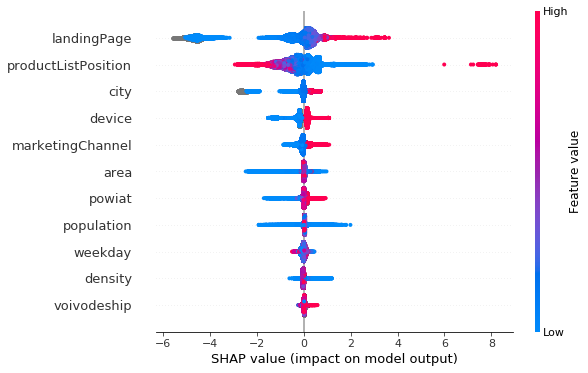

In [35]:
shap.summary_plot(shap_values, X_transformed)

Ważność zmiennych wg oceny SHAP przedstawia się następująco:

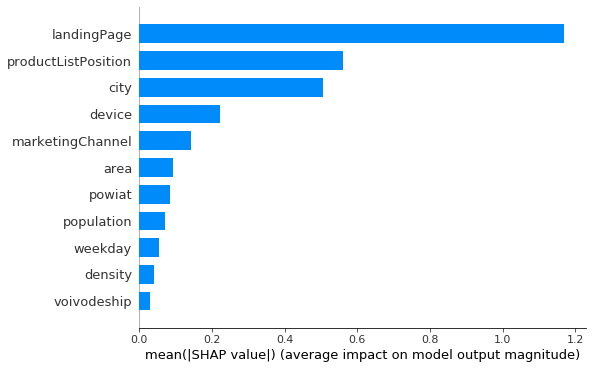

In [36]:
shap.summary_plot(shap_values, X_transformed, plot_type="bar")

#### Model specific feature importance

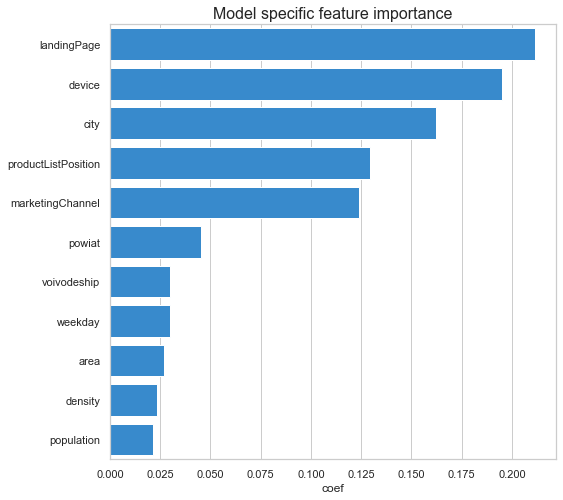

In [37]:
model_specific_feature_importance(X_transformed.columns, xgb_model.feature_importances_)

### PDP Curves + CP cuves

In [38]:
def plot_dp(model, df, feature, nPoints, size=2000):
    sns.set(rc={'figure.figsize':(15,12)})
    sns.set_style("whitegrid")
    sns.set_context("paper")
    featureRange = (df.loc[:, feature].min(), df.loc[:, feature].max())
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    y_cum = []
    df_columns = df.columns
    for row_index in tqdm(range(df.sample(size).shape[0])):
        sample = pd.DataFrame(columns=df_columns)
        sample.loc[0] = df.iloc[row_index, :]
        samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = model.predict_proba(samples)[:,1]
        y_cum.append(y)
        plt.plot(x, y, color="gray", linewidth=0.5, alpha = 0.4)
        sample_x = sample.loc[:, feature]
        sample_prob = model.predict_proba(sample)[:,1]
        plt.plot(sample_x, sample_prob, "o", markersize=3, color="black", alpha=0.6)
    y_cum = np.array(y_cum).mean(axis=0)
    plt.plot(x, y_cum, color="navy", linewidth=5)
    plt.ylabel("Result")
    plt.ylim(0,1)
    plt.title("PDP curve for {}".format(feature))

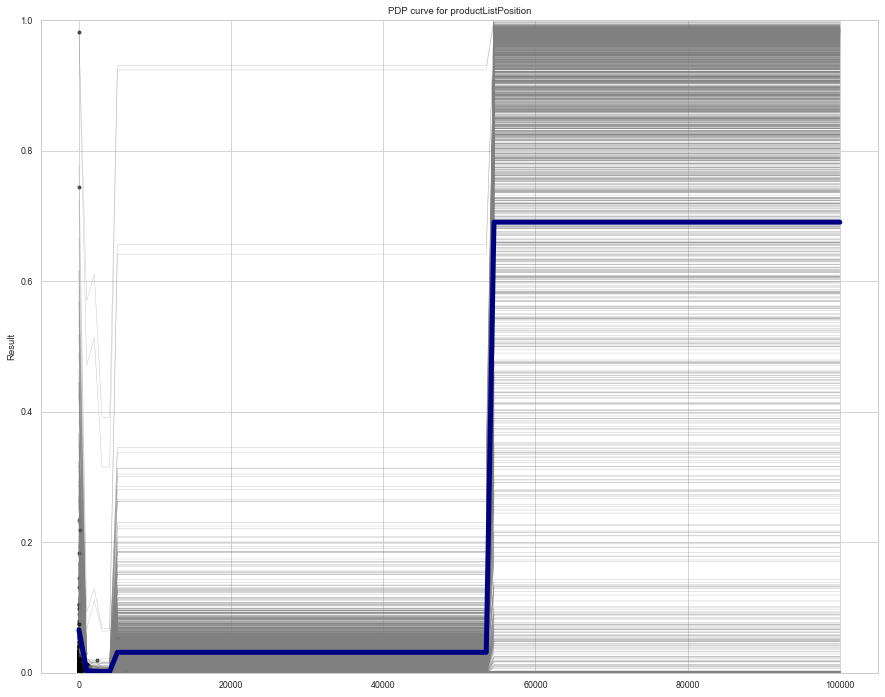

In [39]:
plot_dp(xgb_model, X_transformed, "productListPosition", 100)

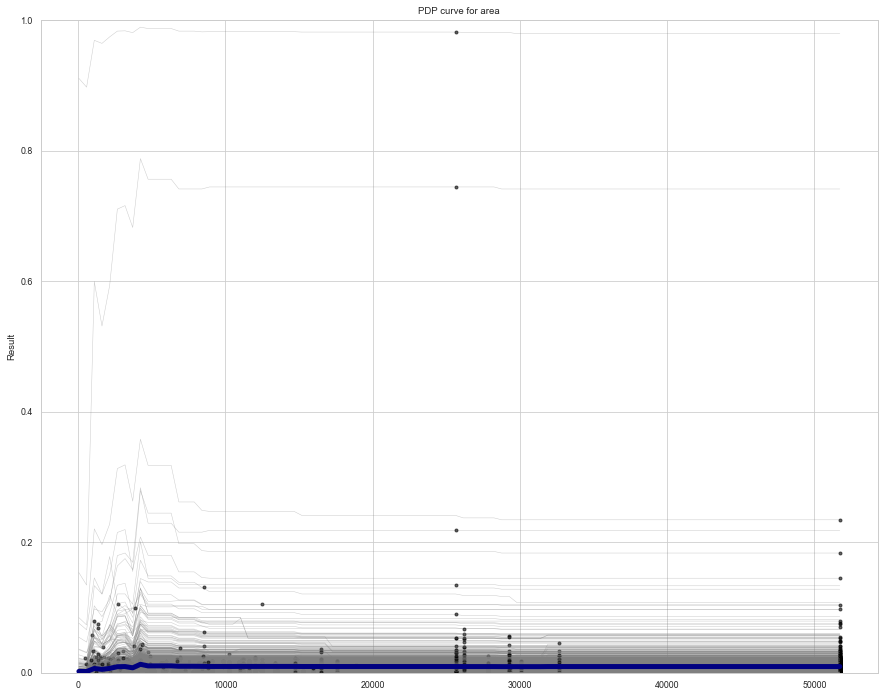

In [40]:
plot_dp(xgb_model, X_transformed, "area", 100)

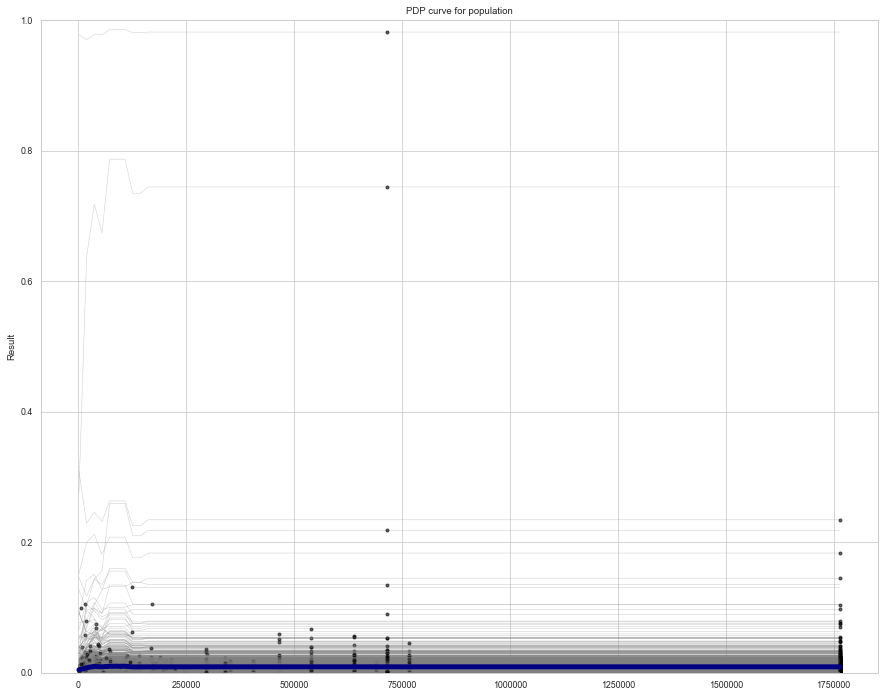

In [41]:
plot_dp(xgb_model, X_transformed, "population", 100)

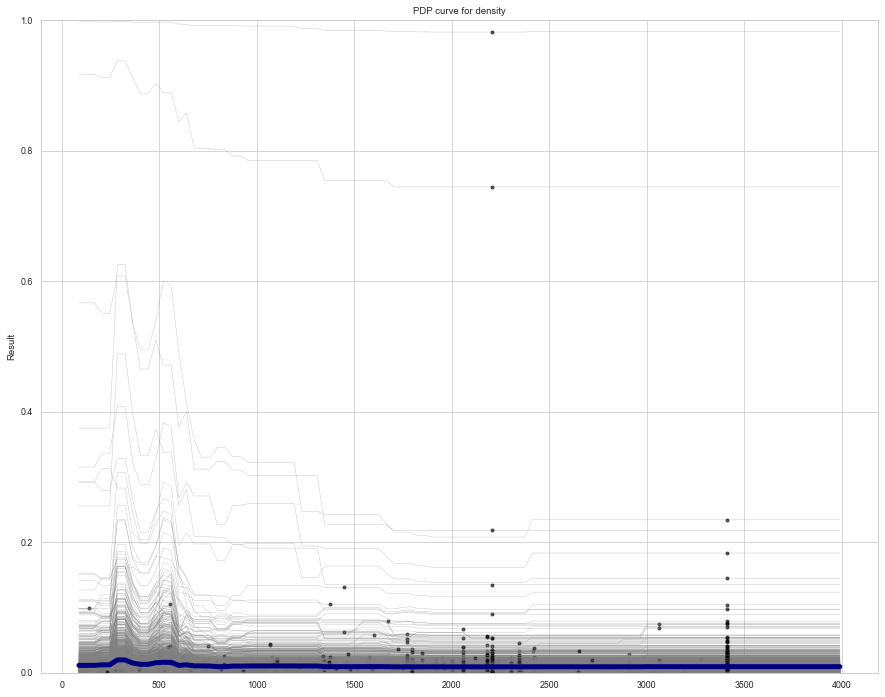

In [42]:
plot_dp(xgb_model, X_transformed, "density", 100)

Zaobserwować można, że dla wszystkich zmiennych (poza `productListPosition`) krzywe PDP mają płaski przebieg, chociaż poszczególne krzywe CP mają zmienny przebieg (mogą to być niewykryte wcześniej outliery).